# Final solution

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_metric

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForMaskedLM, BertTokenizerFast

import re
import torch
from scipy.sparse import vstack
from transformers import pipeline

from condbert import CondBertRewriter
from choosers import EmbeddingSimilarityChooser
from masked_token_predictor_bert import MaskedTokenPredictorBert

from tqdm import tqdm
from collections import defaultdict

## Data observation and analysis

Implement processed(in first notebook) dataset.

In [2]:
dataset = pd.read_csv('../data/interim/processed_dataset.csv')
dataset

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.785171,0.010309,0.981983,0.014195
1,you're becoming disgusting.,Now you're getting nasty.,0.749687,0.071429,0.999039,0.065473
2,"well, we can spare your life.","Well, we could spare your life, for one.",0.919051,0.268293,0.985068,0.213313
3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.664333,0.309524,0.994215,0.053362
4,I have orders to kill her.,I've got orders to put her down.,0.726639,0.181818,0.999348,0.009402
...,...,...,...,...,...,...
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...,0.870322,0.030769,0.949143,0.000121
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


Plote histograms that shows the distribution of toxic scores in toxic and non-toxic sentences.

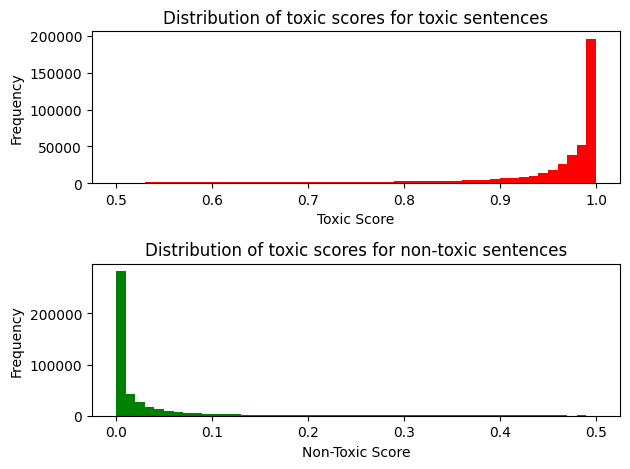

In [40]:
toxic_scores = list(dataset['ref_tox'][:460000])
nontoxic_scores = list(dataset['trn_tox'][:460000])

fig, axs = plt.subplots(2)

# Plotting histogram for toxic sentences
axs[0].hist(toxic_scores, bins=50, color='red')
axs[0].set_title('Distribution of toxic scores for toxic sentences')
axs[0].set(xlabel='Toxic Score', ylabel='Frequency')

# Plotting histogram for non-toxic sentences
axs[1].hist(nontoxic_scores, bins=50, color='green')
axs[1].set_title('Distribution of toxic scores for non-toxic sentences')
axs[1].set(xlabel='Non-Toxic Score', ylabel='Frequency')

plt.tight_layout()
plt.show()

Make lists for toxic/non-toxic sentences and their labels.

In [4]:
toxic_sentence = list(dataset['reference'][:460000])
nontoxic_sentence = list(dataset['translation'][:460000])
toxic_labels = [1 for i in range(len(toxic_sentence))]
nontoxic_labels = [0 for i in range(len(nontoxic_sentence))]

In [39]:
print(toxic_sentence[0:10])
nontoxic_sentence[0:10]

['if Alkar floods her with her mental waste, it would explain the high levels of neurotransmitter.', "you're becoming disgusting.", 'well, we can spare your life.', 'monkey, you have to wake up.', 'I have orders to kill her.', "I'm not gonna have a child... ...with the same genetic disorder as me who's gonna die. L...", "They're all laughing at us, so we'll kick your ass.", 'Maine was very short on black people back then.', 'Briggs, what the hell is going on?', "another simply didn't know what to do, so whenever he met my brother, he nearly beat the shit out of him."]


['If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters.',
 "Now you're getting nasty.",
 'Well, we could spare your life, for one.',
 "Ah! Monkey, you've got to snap out of it.",
 "I've got orders to put her down.",
 "I'm not going to breed kids with a genetic disorder that makes them die.",
 "they're laughing at us. We'll show you.",
 "there wasn't much black in Maine then.",
 "Briggs, what the hell's happening?",
 "Another one simply had no clue what to do, so whenever he met my brother he'd beat the crap out of him, and then say:"]

## Logistic regression for word toxicities scores

Optimize the logistic regression model we’ve previously implemented in the notebook to enhance its efficiency.

In [6]:
# Initialize the CountVectorizer with a limited number of features
vectorizer = CountVectorizer(max_features=100000)

# Vectorize the toxic and non-toxic sentences separately to save memory
X_toxic = vectorizer.fit_transform(toxic_sentence)
X_nontoxic = vectorizer.transform(nontoxic_sentence)

# Stack the vectorized sentences
X = vstack([X_toxic, X_nontoxic])

# Prepare the labels
labels = toxic_labels + nontoxic_labels

# Train the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X, labels)

# Get the feature names (words) and their weights from the logistic regression model
feature_names = vectorizer.get_feature_names_out()
feature_weights = lr_model.coef_[0]

# Create a dictionary mapping words to their toxicity scores (weights)
word_toxicity_scores = dict(zip(feature_names, feature_weights))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\markz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

In [41]:
word_toxicity_scores

{'00': -0.07952509867685263,
 '000': -0.08393902208502917,
 '0000': -0.061336911293700974,
 '000s': 0.10231465305138994,
 '000th': -0.02577571037135144,
 '007': -0.09868692670135244,
 '00or': 0.009217858796838943,
 '00tomorrow': 0.027292241082563593,
 '01': -0.033032671148272776,
 '0105928147218': 0.0007851918332688597,
 '0106': -0.03279602944491221,
 '011': 0.059462301547843543,
 '02': -0.009548053211620363,
 '0200': 0.007986722430991543,
 '0352': 0.03267782484297921,
 '040': -0.013151646576868023,
 '05': -0.0026833470412749288,
 '056': 0.01857223389131019,
 '06': 0.05604155191853959,
 '07': 0.028065528137996513,
 '09': -0.11971546172778018,
 '0900': 0.03981065905478269,
 '09er': -0.030742280755526406,
 '0h': -0.040423184929505585,
 '0kay': 0.028621283099074815,
 '0ne': -0.0130834851627663,
 '0nly': -0.05361573381623295,
 '0pen': 0.09571284471319379,
 '0r': 0.015252019701170412,
 '0therwise': 0.018536441909949623,
 '0ur': 0.0019920265211722642,
 '0ut': 0.0008106587219690989,
 '10': -0

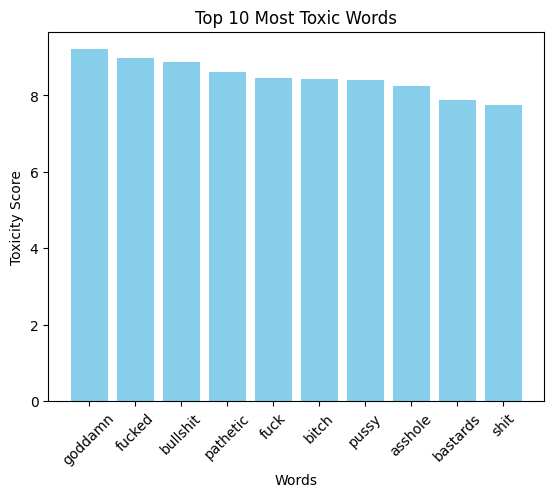

In [45]:
# Get the top 10 most toxic words
top_toxic_words = sorted(word_toxicity_scores.items(), key=lambda x: x[1], reverse=True)[:10]
words, scores = zip(*top_toxic_words)

plt.bar(words, scores, color='skyblue')
plt.title('Top 10 Most Toxic Words')
plt.xlabel('Words')
plt.ylabel('Toxicity Score')
plt.xticks(rotation=45)
plt.show()

## Initializing toxic and positibe words according to their toxicity scores

Enhance the efficiency of the algorithm we used in the previous notebook, and add the identification of positive words as well.

In [8]:
# Combine toxic and non-toxic sentences
sentences = toxic_sentence + nontoxic_sentence

# Initialize lists to store toxic and non-toxic words
toxic_words_in_sentences = []
non_toxic_words_in_sentences = []

# Iterate over sentences
for sentence in sentences:
    # Split the sentence into words, considering punctuation
    words = re.findall(r'\b\w+\b', sentence)
    
    # Compute the toxicity scores for the words
    scores = [word_toxicity_scores.get(word, 0) for word in words]
    
    # Compute the threshold only if scores is not empty
    if scores:
        t1 = max(0.2, max(scores)/2)
        t2 = min(-0.2, min(scores)/2)
    else:
        t1 = 0.2
        t2 = -0.2

    # Find the toxic and non-toxic words
    toxic_words = [word for word, score in zip(words, scores) if score > t1]
    non_toxic_words = [word for word, score in zip(words, scores) if score <= t2]
    
    toxic_words_in_sentences.extend(toxic_words)
    non_toxic_words_in_sentences.extend(non_toxic_words)

# Make words unique by converting lists to sets
toxic_words_in_sentences = list(set(toxic_words_in_sentences))
non_toxic_words_in_sentences = list(set(non_toxic_words_in_sentences))

In [42]:
toxic_words_in_sentences[:10]

['serpents',
 'shite',
 'doll',
 'sucky',
 'mosque',
 'stupid',
 'attack',
 'tramp',
 'screwy',
 'taliban']

In [43]:
non_toxic_words_in_sentences[:10]

['elevators',
 'pinheads',
 'cushions',
 'biker',
 'carrying',
 'boards',
 'missions',
 'formidable',
 'available',
 'appointment']

## Calculating toxicity ratios for text tokens

The log_odds_ratios value indicates the frequency of a word’s appearance in toxic/non-toxic sentences.

In [11]:
# Function to count token occurrences
def count_tokens(texts):
    counter = defaultdict(lambda: 1)
    for text in tqdm(texts):
        tokens = tokenizer.encode(text)
        for token in tokens:
            counter[token] += 1
    return counter

# Count tokens
toxic_counts = count_tokens(toxic_sentence)
nontoxic_counts = count_tokens(nontoxic_sentence)
        
# Calculate toxicity ratios
toxicity_ratios = [toxic_counts[i] / (nontoxic_counts[i] + toxic_counts[i]) for i in range(len(tokenizer.vocab))]
toxicity_ratios = np.array(toxicity_ratios)
log_odds_ratios = np.maximum(0, np.log(toxicity_ratios / (1 - toxicity_ratios)))

# discourage meaningless tokens
for token in ['.', ',', '-', ';', "'"]:
    token_id = tokenizer.encode(token)[1]
    log_odds_ratios[token_id] = 3
    
for token in ['you', 'the']:
    token_id = tokenizer.encode(token)[1]
    log_odds_ratios[token_id] = 0

print(log_odds_ratios[1000:1100])

100%|████████████████████████████████████████████████████████████████████████| 460000/460000 [01:59<00:00, 3833.43it/s]

[0.         0.         0.09807049 0.         0.02439145 3.
 0.         0.         0.         0.31845373 3.         3.
 3.         0.         0.         0.00664454 0.41154415 0.03454033
 0.04485057 0.06899287 0.         0.32004736 0.2006707  0.
 0.         3.         0.         0.         0.06899287 0.
 0.         0.         0.         0.         0.         0.
 0.2572846  0.08590271 0.         0.         0.09870107 0.
 0.01503788 0.         0.34016001 0.         0.         0.
 0.         0.         0.033416   0.         0.02230576 0.14518201
 0.12541666 0.         0.         0.09472096 0.         0.
 0.         0.19597365 0.         0.         0.         0.
 0.37156356 0.         0.         0.69314718 0.         0.
 0.         0.         1.38629436 0.         0.69314718 0.
 0.         0.         0.         0.         0.         0.69314718
 0.28768207 0.         0.         0.         0.         0.
 0.         0.         0.69314718 0.         0.18232156 0.
 0.         0.         0.       

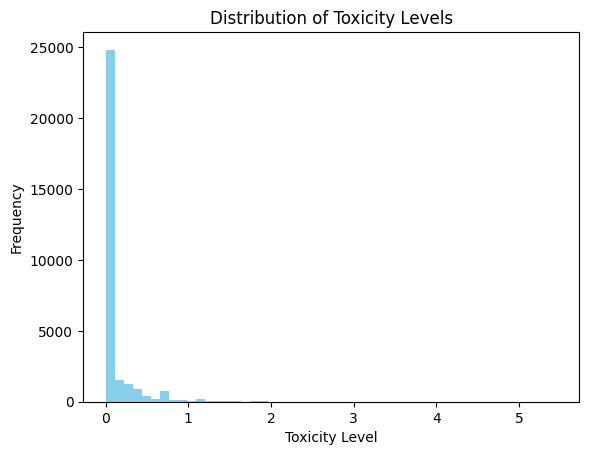

In [44]:
plt.hist(log_odds_ratios, bins=50, color='skyblue')
plt.title('Distribution of Toxicity Levels')
plt.xlabel('Toxicity Level')
plt.ylabel('Frequency')
plt.show()

## Model training 

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
masked_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

def adjust_logits(logits, label=0):
    return logits - log_odds_ratios * 100 * (1 - 2 * label)

predictor = MaskedTokenPredictorBert(masked_model, tokenizer, max_len=250, device=device, label=0,
                                     contrast_penalty=0.0, logits_postprocessor=adjust_logits)

editor = CondBertRewriter(
    model=masked_model,
    tokenizer=tokenizer,
    device=device,
    neg_words=toxic_words_in_sentences,
    pos_words=non_toxic_words_in_sentences,
    word2coef=word_toxicity_scores,
    token_toxicities=log_odds_ratios,
    predictor=predictor,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Prediction and evaluation

In [24]:
X_test = list(dataset['reference'][460000:])
Y_test = list(dataset['translation'][460000:])
Y_test = [[sen] for sen in Y_test]
Y_pred = []

In [25]:
# Add to Y_pred list rewrited sentences
for sentence in X_test:
    Y_pred.append((editor.translate(sentence, prnt=False)))

In [29]:
print(X_test[:10])
print(Y_test[:10])
Y_pred[:10]

["The best treatment for this is to simulate the womb Of the patient's mother using blankets Or a whale's vagina.", "I'm always afraid to tell Véro I fucked her.", 'You are shitting me?!', "Don't be ridiculous.", "I'd like to exterminate this conversation. What are you doing?", 'are you sitting on your butt?', "'Where you from?' said the troll.", 'So how many rooms am I checked into in this shit hole?', "killing us won't bring your boy back.", 'but the fact was that Steve Kemp, published by the poet, a nomadic repairman of furniture, a producer of knitted chairs, a good amateur tennis player and an excellent afternoon lover, was - a swine.']
[["the best treatment is to simulate the womb of a patient's mother... using blankets or whale cars."], ["I'm always scared she'll tell Véro I banged her."], ["you're kidding me."], ["don't be crazy."], ["I'd like to derail this conversation."], ['Are you sitting down?'], ["'will this... are you? 'The troll asked."], ['how many rooms have I logged 

["the best treatment for this is to simulate the womb of the patient ' s mother using blankets or a whale ' s av womb.",
 "i ' m always afraid to tell vero i banged her.",
 'the are kiddinging me?!',
 "don ' t be fooled.",
 "i ' d like to endter silence this conversation. what are you doing?",
 'are you sitting on your back?',
 "' where you from? ' said the troll.",
 'so how many rooms am i checked into in this my hole?',
 "the us won ' t bring your boy back.",
 'but the fact was that steve kemp, published by the poet, a nomadic repairman of furniture, a manufacturer of knitted chairs, a good amateur tennis player and an excellent afternoon lover, was - a swine.']

In [27]:
# Check models effectivity
metric = load_metric("sacrebleu")
metric.compute(predictions=Y_pred, references=Y_test)

{'score': 16.732198041101984,
 'counts': [736396, 325686, 159333, 78808],
 'totals': [1582706, 1464929, 1347163, 1230092],
 'precisions': [46.527655799624185,
  22.232203745027917,
  11.827299294888592,
  6.406675273069006],
 'bp': 1.0,
 'sys_len': 1582706,
 'ref_len': 1407171}